In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
from keras.metrics import Precision, Recall
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob
from unet import UNet
from metrics import dice_loss

In [2]:
IMAGE_DIR = 'dataset/images'
MASK_DIR = 'dataset/segments_single'

H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data():

  images = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))
  masks = sorted(glob(os.path.join(MASK_DIR, "*.png")))
  
  return images, masks


def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (W, H))
  x = x / 255.0
  x = x.astype(np.float32)
  return x


def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (W, H))
  x = x / 255.0  # Optional normalization for segmentation tasks
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=-1)
  return x


def display_image_mask(image_path, mask_path):
  image = read_image(image_path)
  mask = read_mask(mask_path)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image)
  ax1.set_title('Image')
  ax1.axis('off')
  ax2.imshow(mask, cmap='gray')
  ax2.set_title('Mask')
  ax2.axis('off')
  plt.tight_layout()
  plt.show()


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

def display_image_mask(image, mask):

  mask = mask.squeeze()  # Remove extra dimension for grayscale mask

  # Display using matplotlib
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image)
  ax1.set_title('Image')
  ax1.axis('off')
  ax2.imshow(mask, cmap='gray')
  ax2.set_title('Mask')
  ax2.axis('off')
  plt.tight_layout()
  plt.show()


In [3]:
images, masks = load_data()

X = []
Y = []

for image_path, mask_path in zip(images, masks):
    image = read_image(image_path)
    mask = read_mask(mask_path)
    X.append(image)
    Y.append(mask)

  # Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

In [4]:
batch_size = 8
num_epochs = 10
validation_split = 0.2
np.random.seed = 12
lr = 1e-4
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "log.csv")

In [5]:
model = UNet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['precision','recall'])

In [7]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.CSVLogger(csv_path)
        ]


In [13]:
history = model.fit(X, Y, validation_split=0.2 , epochs=100, callbacks= callbacks)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6546 - precision: 0.2586 - recall: 1.7118e-05
Epoch 1: val_loss improved from 0.66125 to 0.64252, saving model to model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6546 - precision: 0.2586 - recall: 1.7118e-05 - val_loss: 0.6425 - val_precision: 0.2000 - val_recall: 3.3799e-06
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6291 - precision: 0.4106 - recall: 1.8601e-04
Epoch 2: val_loss did not improve from 0.64252
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6291 - precision: 0.4106 - recall: 1.8601e-04 - val_loss: 0.7413 - val_precision: 0.2000 - val_recall: 3.3799e-06
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.9517 - precision: 0.4508 - recall: 6.0711e-04
Epoch 3: val_loss improved from 0.64252 to 0.63916, saving model to model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9517 - precision: 0.4508 - recall: 6.0711e-04 - val_loss: 0.6392 - val_precision: 0.2000 - val_recall: 3.3799e-06
E

In [14]:
model.save('models/single.keras')

In [15]:
import random

idx = random.randint(0, len(X))

test_image = X[idx]

print(test_image.shape)

ground_truth = Y[idx]

print(ground_truth.shape)

(256, 256, 3)
(256, 256, 1)


In [16]:
import random

idx = random.randint(0, len(X))

test_image = X[idx]
test_image = test_image.reshape((1, H, W, 3))
test_preds = model.predict(test_image)
ground_truth = Y[idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


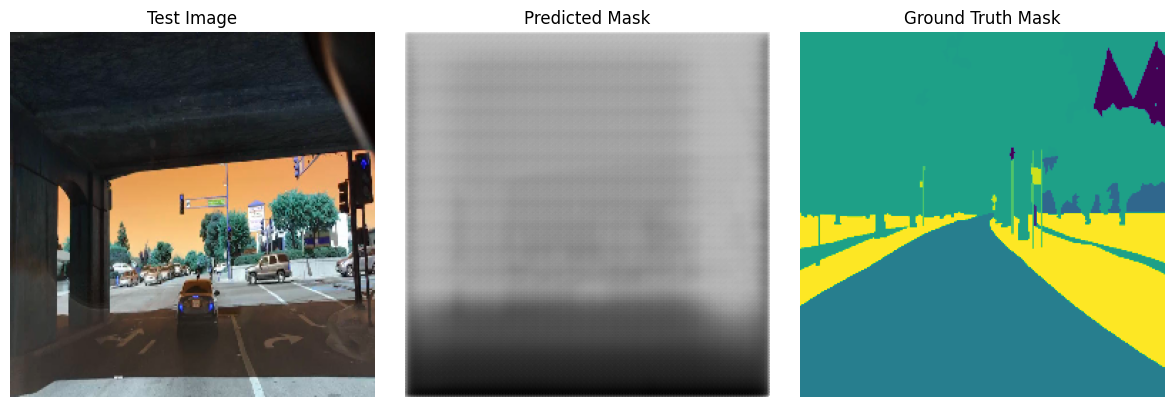

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

test_image = test_image.reshape((H, W, 3))
test_preds = test_preds.reshape((H, W, 1))
ground_truth = ground_truth.reshape((H, W, 1))


axs[0].imshow(test_image)
axs[0].set_title('Test Image')
axs[0].axis('off')

axs[1].imshow(test_preds, cmap='gray')
axs[1].set_title('Predicted Mask')
axs[1].axis('off')

axs[2].imshow(ground_truth)  # Random ground truth mask
axs[2].set_title('Ground Truth Mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()